# Project Description:

In this project, transfer learning using the pre-trained VGG-19 network for Facial Expression Recognition (FER) has been performed, using
4 datasets namely CK+, KDEF, JAFFE, and a subset of FER-2013. We utilized the OpenCV library's functions for various processings on the sample images. The images were read, cropped, resized, and augmented by random rotations and translations using these functions. Images were normalized before feeding to the network for training. An 80-20 train-test split was applied and only the training images were augmented and appended to the original training set. The network's classifier was changed according to the problem, and prior layers were frozen. The training was performed using the Adam optimizer with a learning rate of 0.0001 (10e-4) and a model checkpoint was added to retain the best weights of the model. Training was conducted for 20 epochs and a batch size of 8 was used. Training curves, confusion matrices, and classification reports are provided at the end of each training.

In [47]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import VGG19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [126]:
# Specify the target image size

img_size = 256

# Define function to crop face from sample images

def crop_face(img_path):
    image = cv2.imread(img_path)
    image = cv2.resize(image, (img_size, img_size))
    
    # Convert into grayscale 
    im_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 
  
    # Detect faces 
    faces = face_cascade.detectMultiScale(im_gray, 1.1, 4)

    if len(faces) > 0:
        for (x, y, w, h) in faces: 
            cv2.rectangle(image, (x, y), (x+w, y+h),  
                          (0, 0, 255), 2) 
              
            image = image[y:y + h, x:x + w]
            image = cv2.resize(image, (img_size, img_size))

    return image

# Data augmentation functions

def rotate_image(image):

    # Random rotation
    rows, cols, _ = image.shape
    angle = np.random.uniform(-5, 5)  # Random angle between -5 and 5 degrees
    matrix = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    image_rotated = cv2.warpAffine(image, matrix, (cols, rows))

    return image_rotated

def translate_image(image):
    # Random translation between -5 to 5
    rows, cols, _ = image.shape
    tx = np.random.randint(-5, 5)
    ty = np.random.randint(-5, 5)
    translation_matrix = np.float32([[1, 0, tx], [0, 1, ty]])
    image_translated = cv2.warpAffine(image, translation_matrix, (cols, rows))

    return image_translated

In [3]:
# Load the images paths and emotion labels of JAFFE dataset into a dataframe

jaffe_dir = "/kaggle/input/jaffe-dataset/jaffe/"

image_path = []
labels = []
emotion_labels = {
    "ANG": 0, "DIS": 1, "FEA": 2, "HAP": 3, "NEU": 4, "SAD": 5, "SUR": 6
}

for emotion in emotion_labels.keys():
    emotion_path = os.path.join(jaffe_dir, emotion)
    
    for filename in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, filename)
        image_path.append(img_path)
        labels.append(emotion_labels[emotion])

# dataframe for emotion of files
jaffe_emotion_df = pd.DataFrame(labels, columns=['Emotions'])
# dataframe for path of files.
jaffe_path_df = pd.DataFrame(image_path, columns=['Path'])
# Combined dataframe
jaffe_df = pd.concat([jaffe_emotion_df, jaffe_path_df], axis=1)

Text(0.5, 1.0, 'Cropped, Translated, and Rotated')

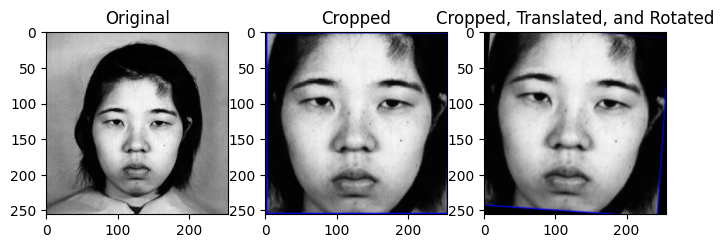

In [90]:
# Visualization of augmented images

img_path = jaffe_df.Path[0]
plt.figure(figsize=(8, 8))
plt.subplot(1,3,1)
imgplot = plt.imshow(cv2.imread(img_path))
plt.title('Original')
plt.subplot(1,3,2)
imgplot = plt.imshow(crop_face(img_path))
plt.title('Cropped')
plt.subplot(1,3,3)
imgplot = plt.imshow(rotate_image(translate_image(crop_face(img_path))))
plt.title('Cropped, Translated, and Rotated')

In [43]:
# Split dataframe before Augmentation

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(jaffe_df, test_size = 0.2, random_state = 42)

In [91]:
# Reading the Training set

X_train,Y_train=[],[]
for path,emotion,index in zip(train_df.Path,train_df.Emotions,range(train_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_train.append(image) # Append to train set
    Y_train.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Normalize images between 0 & 1
X_train = cv2.normalize(X_train, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_train = to_categorical(Y_train, num_classes=7)

Done


In [96]:
# Reading the Test set

X_test,Y_test=[],[]
for path,emotion,index in zip(test_df.Path,test_df.Emotions,range(test_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_test.append(image) # Append to test set
    Y_test.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Normalize images between 0 & 1
X_test = cv2.normalize(X_test, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_test = to_categorical(Y_test, num_classes=7)

Done


In [93]:
# Augment the Train set

aug_df = train_df # Apply augmentation only to the training set
X_aug,Y_aug=[],[]
for path,emotion,index in zip(aug_df.Path,aug_df.Emotions,range(aug_df.Path.shape[0])):
    image = crop_face(path) # crop face
    X_aug.append(rotate_image(translate_image(image))) # Append the translated-rotated image
    Y_aug.append(emotion) # Append the corresponding label
    
print('Done')

# Convert lists to numpy arrays
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

# Normalize images between 0 & 1
X_aug = cv2.normalize(X_aug, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
X_train = np.vstack((X_train, X_aug))

# One-hot encode the labels (7 categories)
Y_aug = to_categorical(Y_aug, num_classes=7)
Y_train = np.vstack((Y_train, Y_aug))

Done


In [98]:
# Load pre-trained VGG19 model for transfer learning (without the top classification layer)
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False

from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath ='/kaggle/working/best_finetuned_jaffe_weights.keras', monitor='val_accuracy', mode = 'max', save_best_only=True)

# Add custom layers on top for emotion classification
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 output classes for emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [99]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=8, callbacks=[model_checkpoint])

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 96ms/step - accuracy: 0.1668 - loss: 2.2786 - val_accuracy: 0.2791 - val_loss: 1.6312
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.5141 - loss: 1.3705 - val_accuracy: 0.3953 - val_loss: 1.2477
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - accuracy: 0.7349 - loss: 0.8226 - val_accuracy: 0.8140 - val_loss: 0.7851
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.9336 - loss: 0.5182 - val_accuracy: 0.9302 - val_loss: 0.5584
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9805 - loss: 0.3331 - val_accuracy: 0.8837 - val_loss: 0.4852
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9888 - loss: 0.2069 - val_accuracy: 0.9302 - val_loss: 0.4023
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.9934 - loss: 0.1670 - val_accuracy: 0.9535 - val_loss: 0.3411
Epoch 8/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - accuracy: 0.9983 - loss: 0.1448 - val_accuracy: 0.9070 - v

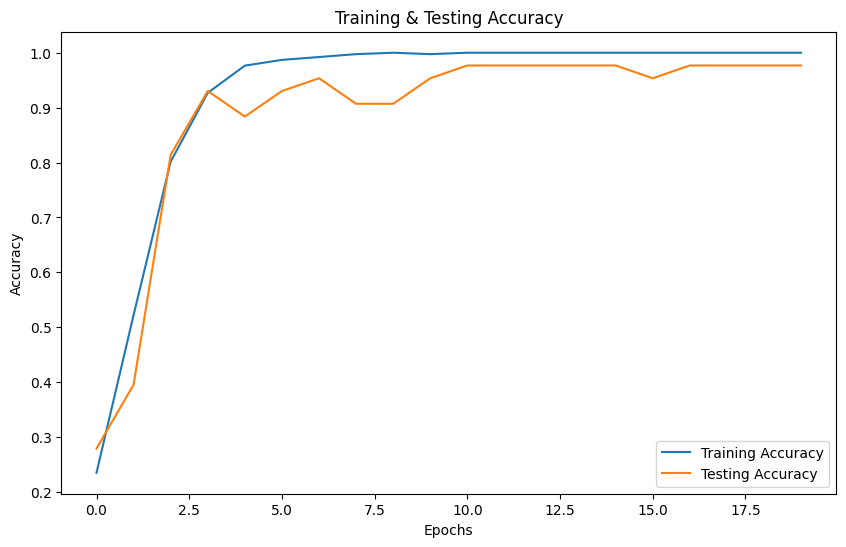

In [100]:
epochs = [i for i in range(20)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (10,6))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()

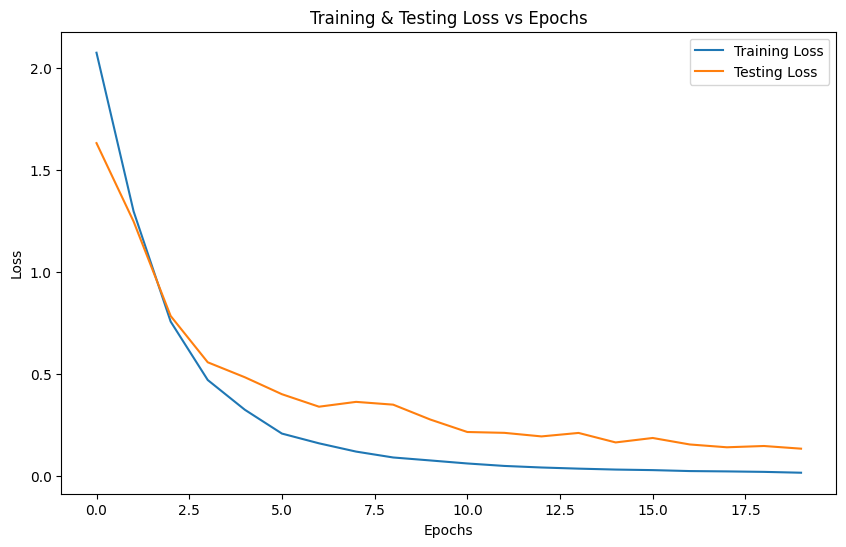

In [101]:
plt.figure(figsize = (10,6))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

In [102]:
model.load_weights(filepath ='/kaggle/working/best_finetuned_jaffe_weights.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 5s/step - accuracy: 0.9845 - loss: 0.2024
Accuracy of our model on test data :  97.67441749572754 %


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step


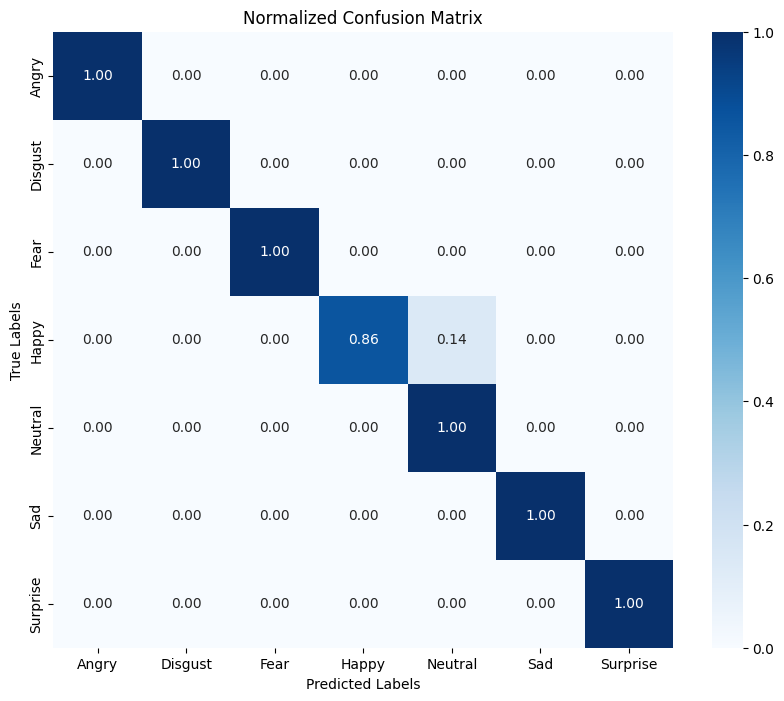

Classification Report:
              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00         5
     Disgust       1.00      1.00      1.00         3
        Fear       1.00      1.00      1.00         7
       Happy       1.00      0.86      0.92         7
     Neutral       0.80      1.00      0.89         4
         Sad       1.00      1.00      1.00         8
    Surprise       1.00      1.00      1.00         9

    accuracy                           0.98        43
   macro avg       0.97      0.98      0.97        43
weighted avg       0.98      0.98      0.98        43



In [103]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=class_labels))

In [104]:
# Load the images paths and emotion labels of CK+ dataset into a dataframe

ckp_dir = "/kaggle/input/ck-dataset/"

image_path = []
labels = []
emotion_labels = {
    "anger": 0, "disgust": 1, "fear": 2, "happy": 3, "contempt": 4, "sadness": 5, "surprise": 6
}

for emotion in emotion_labels.keys():
    emotion_path = os.path.join(ckp_dir, emotion)
    
    for filename in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, filename)
        image_path.append(img_path)
        labels.append(emotion_labels[emotion])

# dataframe for emotion of files
ckp_emotion_df = pd.DataFrame(labels, columns=['Emotions'])
# dataframe for path of files.
ckp_path_df = pd.DataFrame(image_path, columns=['Path'])
# Combined dataframe
ckp_df = pd.concat([ckp_emotion_df, ckp_path_df], axis=1)

Text(0.5, 1.0, 'Cropped, Translated, and Rotated')

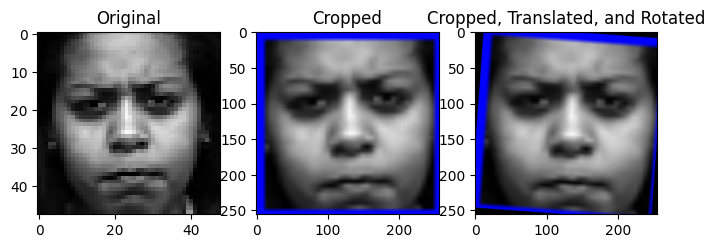

In [105]:
# Visualization of augmented images

img_path = ckp_df.Path[0]
plt.figure(figsize=(8, 8))
plt.subplot(1,3,1)
imgplot = plt.imshow(cv2.imread(img_path))
plt.title('Original')
plt.subplot(1,3,2)
imgplot = plt.imshow(crop_face(img_path))
plt.title('Cropped')
plt.subplot(1,3,3)
imgplot = plt.imshow(rotate_image(translate_image(crop_face(img_path))))
plt.title('Cropped, Translated, and Rotated')

In [106]:
# Split dataframe before Augmentation

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(ckp_df, test_size = 0.2, random_state = 42)

In [107]:
# Reading the Training set

X_train,Y_train=[],[]
for path,emotion,index in zip(train_df.Path,train_df.Emotions,range(train_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_train.append(image) # Append to train set
    Y_train.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Normalize images between 0 & 1
X_train = cv2.normalize(X_train, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_train = to_categorical(Y_train, num_classes=7)

Done


In [108]:
# Reading the Test set

X_test,Y_test=[],[]
for path,emotion,index in zip(test_df.Path,test_df.Emotions,range(test_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_test.append(image) # Append to train set
    Y_test.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Normalize images between 0 & 1
X_test = cv2.normalize(X_test, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_test = to_categorical(Y_test, num_classes=7)

Done


In [109]:
# Augment the Train set

aug_df = train_df # Apply augmentation only to the training set
X_aug,Y_aug=[],[]
for path,emotion,index in zip(aug_df.Path,aug_df.Emotions,range(aug_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_aug.append(rotate_image(translate_image(image))) # Append the translated-rotated image
    Y_aug.append(emotion) # Append the corresponding label
    
print('Done')

# Convert lists to numpy arrays
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

# Normalize images between 0 & 1
X_aug = cv2.normalize(X_aug, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
X_train = np.vstack((X_train, X_aug))

# One-hot encode the labels (7 categories)
Y_aug = to_categorical(Y_aug, num_classes=7)
Y_train = np.vstack((Y_train, Y_aug))

Done


In [110]:
# Load pre-trained VGG19 model for transfer learning (without the top classification layer)
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False

from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath ='/kaggle/working/best_finetuned_ckp_weights.keras', monitor='val_accuracy', mode = 'max', save_best_only=True)

# Add custom layers on top for emotion classification
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 output classes for emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [111]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=8, callbacks=[model_checkpoint])

Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 16s 64ms/step - accuracy: 0.4945 - loss: 1.4602 - val_accuracy: 0.8782 - val_loss: 0.4543
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9015 - loss: 0.3421 - val_accuracy: 0.9289 - val_loss: 0.2599
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9664 - loss: 0.1531 - val_accuracy: 0.9949 - val_loss: 0.1029
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - accuracy: 0.9885 - loss: 0.0846 - val_accuracy: 1.0000 - val_loss: 0.0646
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.9972 - loss: 0.0364 - val_accuracy: 1.0000 - val_loss: 0.0458
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 0.9997 - loss: 0.0313 - val_accuracy: 1.0000 - val_loss: 0.0315
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 1.0000 - loss: 0.0179 - val_accuracy: 1.0000 - val_loss: 0.0289
Epoch 8/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - accuracy: 1.0000 - loss: 0.0152 - val_acc

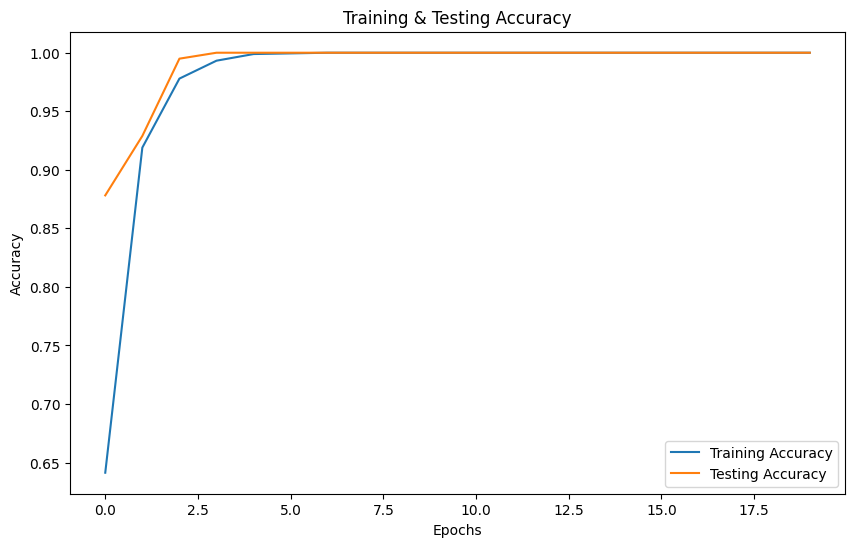

In [112]:
epochs = [i for i in range(20)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (10,6))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()

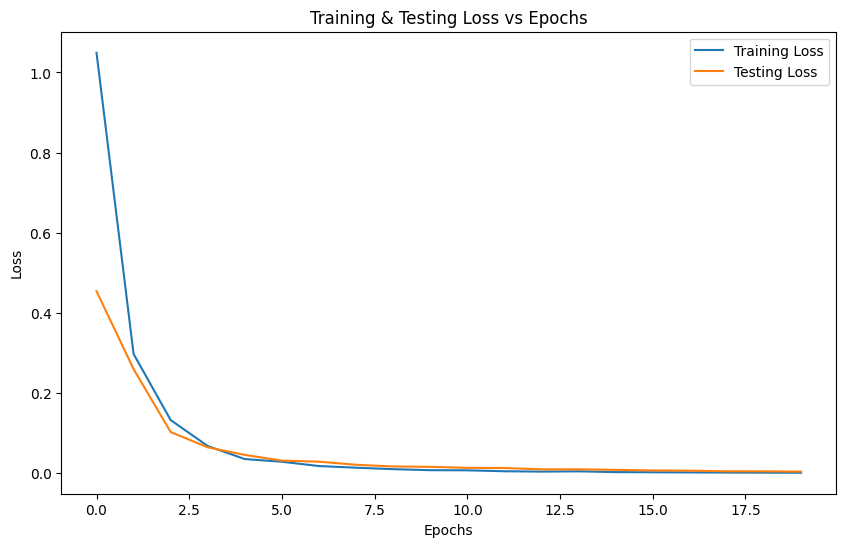

In [113]:
plt.figure(figsize = (10,6))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

In [114]:
model.load_weights(filepath ='/kaggle/working/best_finetuned_ckp_weights.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 1.0000 - loss: 0.0590
Accuracy of our model on test data :  100.0 %


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 156ms/step


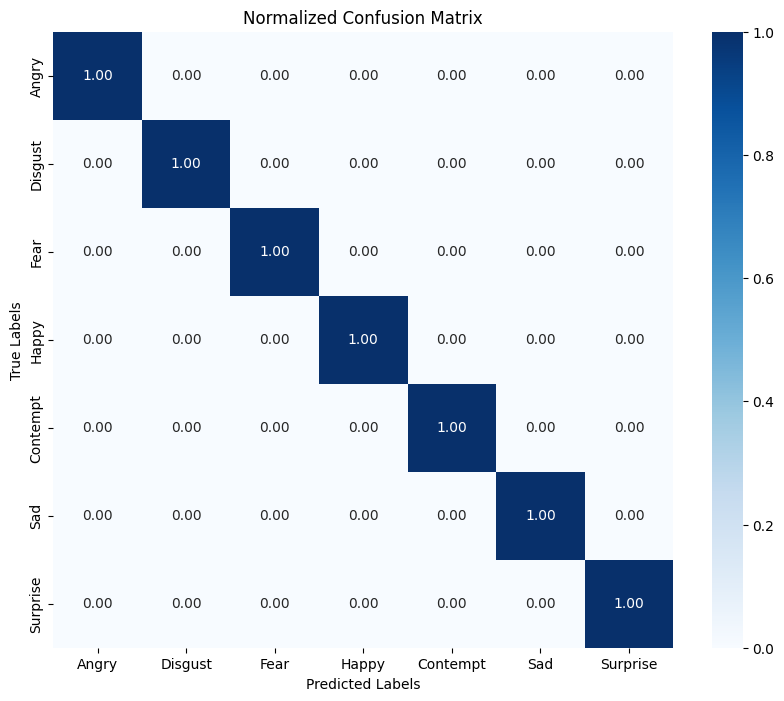

Classification Report:
              precision    recall  f1-score   support

       Angry       1.00      1.00      1.00        23
     Disgust       1.00      1.00      1.00        36
        Fear       1.00      1.00      1.00        19
       Happy       1.00      1.00      1.00        43
    Contempt       1.00      1.00      1.00        12
         Sad       1.00      1.00      1.00        19
    Surprise       1.00      1.00      1.00        45

    accuracy                           1.00       197
   macro avg       1.00      1.00      1.00       197
weighted avg       1.00      1.00      1.00       197



In [115]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Contempt', 'Sad', 'Surprise']

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=class_labels))

In [117]:
# Load the images paths and emotion labels of KDEF dataset into a dataframe

kdef_dir = "/kaggle/input/testtt/"

image_path = []
labels = []
emotion_labels = {
    "angry": 0, "disgust": 1, "fear": 2, "happy": 3, "neutral": 4, "sad": 5, "surprise": 6
}

for emotion in emotion_labels.keys():
    emotion_path = os.path.join(kdef_dir, emotion)
    
    for filename in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, filename)
        image_path.append(img_path)
        labels.append(emotion_labels[emotion])

# dataframe for emotion of files
kdef_emotion_df = pd.DataFrame(labels, columns=['Emotions'])
# dataframe for path of files.
kdef_path_df = pd.DataFrame(image_path, columns=['Path'])
# Combined dataframe
kdef_df = pd.concat([kdef_emotion_df, kdef_path_df], axis=1)

Text(0.5, 1.0, 'Cropped, Translated, and Rotated')

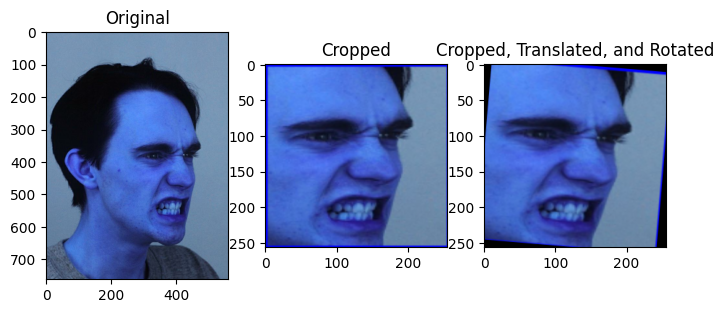

In [129]:
# Visualization of augmented images

img_path = kdef_df.Path[0]
plt.figure(figsize=(8, 8))
plt.subplot(1,3,1)
imgplot = plt.imshow(cv2.imread(img_path))
plt.title('Original')
plt.subplot(1,3,2)
imgplot = plt.imshow(crop_face(img_path))
plt.title('Cropped')
plt.subplot(1,3,3)
imgplot = plt.imshow(rotate_image(translate_image(crop_face(img_path))))
plt.title('Cropped, Translated, and Rotated')

In [119]:
# Split dataframe before Augmentation

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(kdef_df, test_size = 0.2, random_state = 42)

In [127]:
# Reading the Training set

X_train,Y_train=[],[]
for path,emotion,index in zip(train_df.Path,train_df.Emotions,range(train_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_train.append(image) # Append to train set
    Y_train.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Normalize images between 0 & 1
X_train = cv2.normalize(X_train, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_train = to_categorical(Y_train, num_classes=7)

Done


In [130]:
# Reading the Test set

X_test,Y_test=[],[]
for path,emotion,index in zip(test_df.Path,test_df.Emotions,range(test_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_test.append(image) # Append to train set
    Y_test.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Normalize images between 0 & 1
X_test = cv2.normalize(X_test, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_test = to_categorical(Y_test, num_classes=7)

Done


In [131]:
# Augment the Train set

aug_df = train_df # Apply augmentation only to the training set
X_aug,Y_aug=[],[]
for path,emotion,index in zip(aug_df.Path,aug_df.Emotions,range(aug_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_aug.append(rotate_image(translate_image(image))) # Append the translated-rotated image
    Y_aug.append(emotion) # Append the corresponding label
    
print('Done')

# Convert lists to numpy arrays
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

# Normalize images between 0 & 1
X_aug = cv2.normalize(X_aug, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
X_train = np.vstack((X_train, X_aug))

# One-hot encode the labels (7 categories)
Y_aug = to_categorical(Y_aug, num_classes=7)
Y_train = np.vstack((Y_train, Y_aug))

Done


In [132]:
# Load pre-trained VGG19 model for transfer learning (without the top classification layer)
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False

from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath ='/kaggle/working/best_finetuned_kdef_weights.keras', monitor='val_accuracy', mode = 'max', save_best_only=True)

# Add custom layers on top for emotion classification
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 output classes for emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [133]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=8, callbacks=[model_checkpoint])

Epoch 1/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 30s 42ms/step - accuracy: 0.4120 - loss: 1.5632 - val_accuracy: 0.6888 - val_loss: 0.8332
Epoch 2/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.7938 - loss: 0.6215 - val_accuracy: 0.7891 - val_loss: 0.5929
Epoch 3/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.8862 - loss: 0.3829 - val_accuracy: 0.8027 - val_loss: 0.5145
Epoch 4/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.9474 - loss: 0.2330 - val_accuracy: 0.8333 - val_loss: 0.4378
Epoch 5/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 24s 36ms/step - accuracy: 0.9586 - loss: 0.1795 - val_accuracy: 0.9099 - val_loss: 0.3201
Epoch 6/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.9769 - loss: 0.1131 - val_accuracy: 0.8929 - val_loss: 0.3061
Epoch 7/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.9896 - loss: 0.0805 - val_accuracy: 0.8929 - val_loss: 0.3214
Epoch 8/20
661/661 ━━━━━━━━━━━━━━━━━━━━ 23s 35ms/step - accuracy: 0.9889 - loss: 0.0643 - 

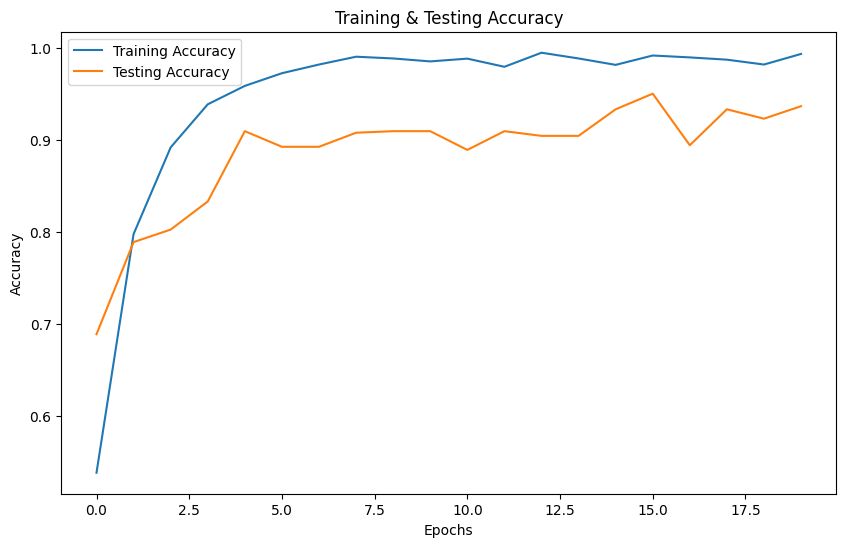

In [134]:
epochs = [i for i in range(20)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (10,6))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()

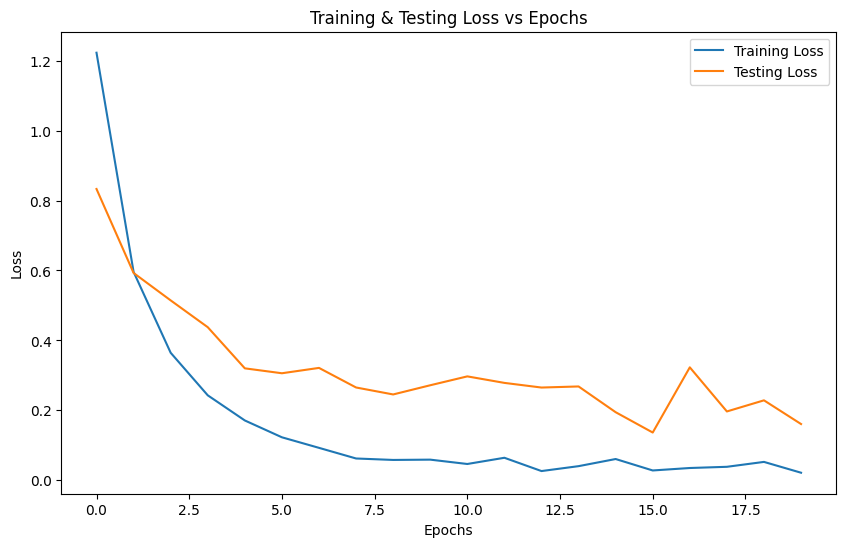

In [135]:
plt.figure(figsize = (10,6))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

In [136]:
model.load_weights(filepath ='/kaggle/working/best_finetuned_kdef_weights.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 412ms/step - accuracy: 0.9378 - loss: 0.1796
Accuracy of our model on test data :  95.06802558898926 %


19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step


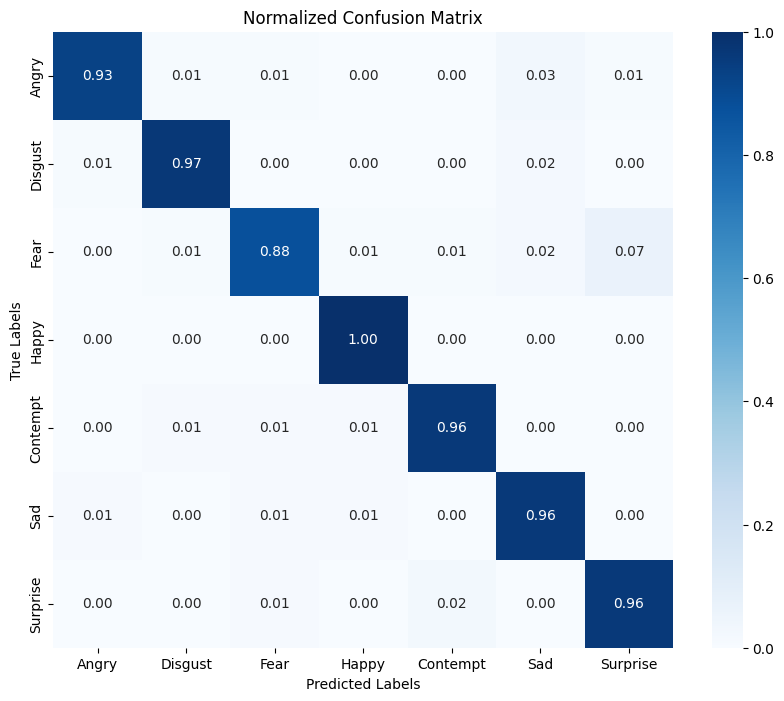

Classification Report:
              precision    recall  f1-score   support

       Angry       0.98      0.93      0.95        90
     Disgust       0.97      0.97      0.97        86
        Fear       0.95      0.88      0.91        90
       Happy       0.96      1.00      0.98        81
    Contempt       0.96      0.96      0.96        80
         Sad       0.91      0.96      0.94        77
    Surprise       0.92      0.96      0.94        84

    accuracy                           0.95       588
   macro avg       0.95      0.95      0.95       588
weighted avg       0.95      0.95      0.95       588



In [137]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Contempt', 'Sad', 'Surprise']

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=class_labels))

In [138]:
# Load the images paths and emotion labels of FER-2013 dataset into a dataframe

fer_dir = "/kaggle/input/fer-dataset/FER/"

image_path = []
labels = []
emotion_labels = {
    "Anger": 0, "Disgust": 1, "Fear": 2, "Happy": 3, "Neutral": 4, "Sad": 5, "Surprise": 6
}

for emotion in emotion_labels.keys():
    emotion_path = os.path.join(fer_dir, emotion)
    
    for filename in os.listdir(emotion_path):
        img_path = os.path.join(emotion_path, filename)
        image_path.append(img_path)
        labels.append(emotion_labels[emotion])

# dataframe for emotion of files
fer_emotion_df = pd.DataFrame(labels, columns=['Emotions'])
# dataframe for path of files.
fer_path_df = pd.DataFrame(image_path, columns=['Path'])
# Combined dataframe
fer_df = pd.concat([fer_emotion_df, fer_path_df], axis=1)

Text(0.5, 1.0, 'Cropped, Translated, and Rotated')

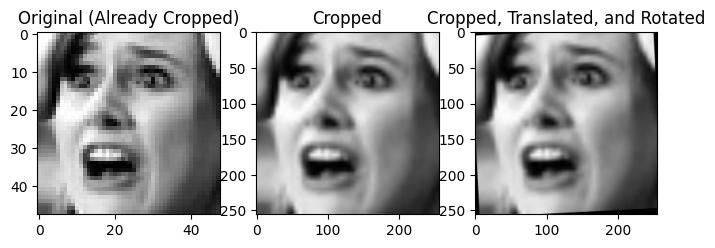

In [141]:
# Visualization of augmented images

img_path = fer_df.Path[0]
plt.figure(figsize=(8, 8))
plt.subplot(1,3,1)
imgplot = plt.imshow(cv2.imread(img_path))
plt.title('Original (Already Cropped)')
plt.subplot(1,3,2)
imgplot = plt.imshow(crop_face(img_path))
plt.title('Cropped')
plt.subplot(1,3,3)
imgplot = plt.imshow(rotate_image(translate_image(crop_face(img_path))))
plt.title('Cropped, Translated, and Rotated')

In [142]:
# Split dataframe before Augmentation

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(fer_df, test_size = 0.2, random_state = 42)

In [144]:
# Reading the Training set

X_train,Y_train=[],[]
for path,emotion,index in zip(train_df.Path,train_df.Emotions,range(train_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_train.append(image) # Append to train set
    Y_train.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_train = np.array(X_train)
Y_train = np.array(Y_train)

# Normalize images between 0 & 1
X_train = cv2.normalize(X_train, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_train = to_categorical(Y_train, num_classes=7)

Done


In [145]:
# Reading the Test set

X_test,Y_test=[],[]
for path,emotion,index in zip(test_df.Path,test_df.Emotions,range(test_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_test.append(image) # Append to train set
    Y_test.append(emotion) # Append the corresponding label
print('Done')

# Convert lists to numpy arrays
X_test = np.array(X_test)
Y_test = np.array(Y_test)

# Normalize images between 0 & 1
X_test = cv2.normalize(X_test, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)

# One-hot encode the labels (7 categories)
Y_test = to_categorical(Y_test, num_classes=7)

Done


In [146]:
# Augment the Train set

aug_df = train_df # Apply augmentation only to the training set
X_aug,Y_aug=[],[]
for path,emotion,index in zip(aug_df.Path,aug_df.Emotions,range(aug_df.Path.shape[0])):
    image = crop_face(path) # Crop face
    X_aug.append(rotate_image(translate_image(image))) # Append the translated-rotated image
    Y_aug.append(emotion) # Append the corresponding label
    
print('Done')

# Convert lists to numpy arrays
X_aug = np.array(X_aug)
Y_aug = np.array(Y_aug)

# Normalize images between 0 & 1
X_aug = cv2.normalize(X_aug, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX)
X_train = np.vstack((X_train, X_aug))

# One-hot encode the labels (7 categories)
Y_aug = to_categorical(Y_aug, num_classes=7)
Y_train = np.vstack((Y_train, Y_aug))

Done


In [148]:
# Load pre-trained VGG19 model for transfer learning (without the top classification layer)
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(img_size, img_size, 3))

# Freeze the layers of the base model to prevent them from being updated during training
base_model.trainable = False

from keras.callbacks import ModelCheckpoint

model_checkpoint = ModelCheckpoint(filepath ='/kaggle/working/best_finetuned_fer_weights.keras', monitor='val_accuracy', mode = 'max', save_best_only=True)

# Add custom layers on top for emotion classification
model = Sequential()
model.add(base_model)
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(7, activation='softmax'))  # 7 output classes for emotions

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [149]:
# Train the model
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=8, callbacks=[model_checkpoint])

Epoch 1/20
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 66s 37ms/step - accuracy: 0.3023 - loss: 1.8261 - val_accuracy: 0.4425 - val_loss: 1.5351
Epoch 2/20
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 61s 36ms/step - accuracy: 0.4689 - loss: 1.4467 - val_accuracy: 0.4990 - val_loss: 1.3720
Epoch 3/20
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - accuracy: 0.5583 - loss: 1.2303 - val_accuracy: 0.5108 - val_loss: 1.2968
Epoch 4/20
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - accuracy: 0.6299 - loss: 1.0636 - val_accuracy: 0.5417 - val_loss: 1.2471
Epoch 5/20
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - accuracy: 0.6827 - loss: 0.9427 - val_accuracy: 0.5476 - val_loss: 1.2521
Epoch 6/20
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - accuracy: 0.7377 - loss: 0.8137 - val_accuracy: 0.5850 - val_loss: 1.1348
Epoch 7/20
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 61s 35ms/step - accuracy: 0.7729 - loss: 0.7076 - val_accuracy: 0.6303 - val_loss: 1.0278
Epoch 8/20
1714/1714 ━━━━━━━━━━━━━━━━━━━━ 60s 35ms/step - accuracy: 0.7999 -

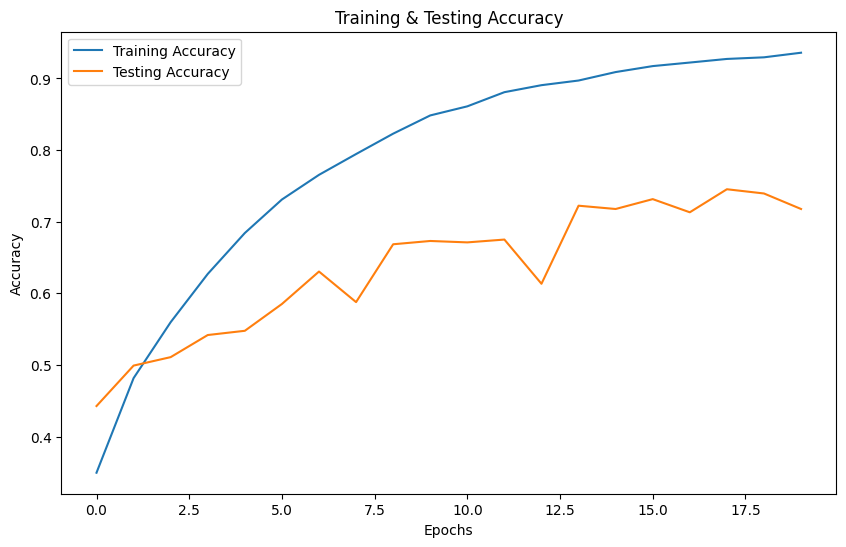

In [150]:
epochs = [i for i in range(20)]
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

plt.figure(figsize = (10,6))
plt.plot(epochs , train_acc , label = 'Training Accuracy')
plt.plot(epochs , test_acc , label = 'Testing Accuracy')
plt.title('Training & Testing Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.savefig('Acc.png', dpi=1200)
plt.show()

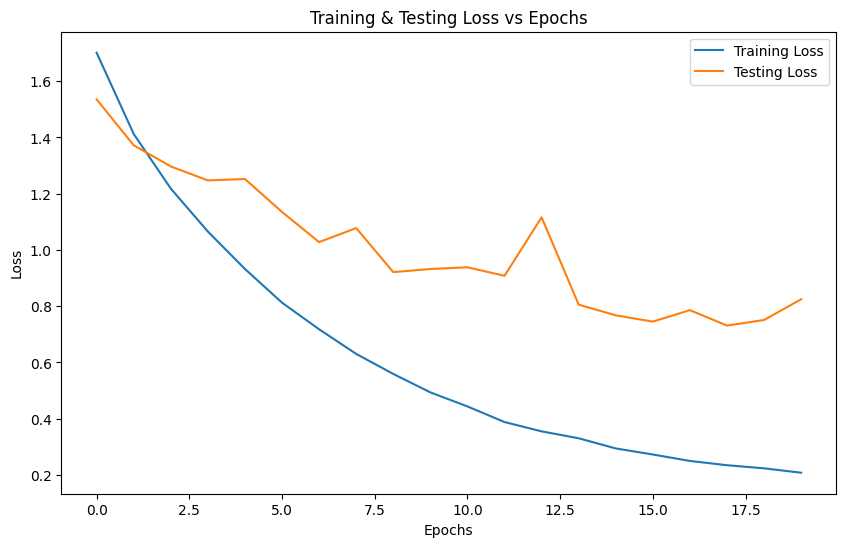

In [151]:
plt.figure(figsize = (10,6))
plt.plot(epochs , train_loss , label = 'Training Loss')
plt.plot(epochs , test_loss , label = 'Testing Loss')
plt.title('Training & Testing Loss vs Epochs')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.savefig('Loss.png', dpi=1200)
plt.show()

In [152]:
model.load_weights(filepath ='/kaggle/working/best_finetuned_fer_weights.keras')
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print("Accuracy of our model on test data : " , model.evaluate(X_test,Y_test)[1]*100 , "%")

48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 235ms/step - accuracy: 0.7621 - loss: 0.6743
Accuracy of our model on test data :  74.52396750450134 %


48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step


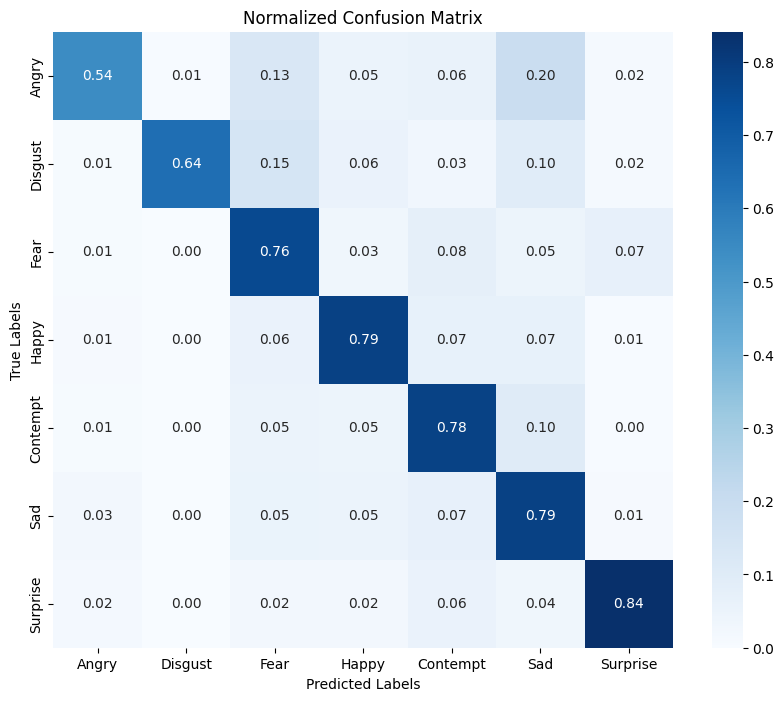

Classification Report:
              precision    recall  f1-score   support

       Angry       0.86      0.54      0.66       199
     Disgust       0.99      0.64      0.78       122
        Fear       0.63      0.76      0.69       209
       Happy       0.83      0.79      0.81       334
    Contempt       0.70      0.78      0.74       249
         Sad       0.62      0.79      0.69       240
    Surprise       0.85      0.84      0.84       170

    accuracy                           0.75      1523
   macro avg       0.78      0.73      0.75      1523
weighted avg       0.77      0.75      0.75      1523



In [153]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(Y_true_classes, Y_pred_classes)

# Normalize confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Define class labels
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Contempt', 'Sad', 'Surprise']

# Plot normalized confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Normalized Confusion Matrix')
plt.savefig('Conf_Mat.png', dpi=1200)
plt.show()

# Print classification report
print("Classification Report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=class_labels))